# Milestone 1 Notebook

#### Authors: Julien Gordon, Adam Morphy, Mukund Iyer, Shiva Shankar Jena

## Questions 1. and 2.

#### Link to Team Contract: https://docs.google.com/document/d/1uDSQLGPSfcgl3PisaC1-ngaViqJCkBiWFmDsN2FzZ9w/edit?usp=sharing
#### Link ot Repo: https://github.com/UBC-MDS/DSCI_525_Group26

## 3. Data Download

In [3]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

In [5]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "../data/"


In [6]:
%%time 
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

CPU times: user 26.2 ms, sys: 16.1 ms, total: 42.3 ms
Wall time: 909 ms


[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [7]:
%%time
files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 3.94 s, sys: 4.43 s, total: 8.37 s
Wall time: 4min 18s


In [9]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 19.6 s, sys: 6.09 s, total: 25.7 s
Wall time: 32.9 s


> Data Download Comparison

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Adam Morphy | MacOS Big Sur | 8GB | 1.8 GHz Dual-Core Intel Core i5 | Yes | |
| Mukund Iyer | MacOS Monterey | 8GB | 1.4 GHz Quad-Core Intel Core i5 | Yes | 258s |
| Julien Gordon | Ubuntu 20.04.4 LTS | 16GB | AMD® Ryzen 7 5800h with radeon graphics | Yes | |
| Shiva Shankar Jena | MacOS Catalina 10.15.7 | 4GB | 1.4 GHz Dual-Core Intel Core i5 | Yes | |

## 4. Combining data CSVs

In [10]:
%%time
files = glob.glob('data/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'[^\/]+?(?=_)', file)[0])
                for file in files)
              )
df.to_csv("data/combined_data.csv")


CPU times: user 7min 8s, sys: 42.1 s, total: 7min 51s
Wall time: 8min 20s


In [5]:
df = pd.read_csv('data/combined_data.csv')

In [1]:
%%sh
du -sh data/combined_data.csv


5.6G	data/combined_data.csv


In [6]:
print(df.shape)

(62467843, 7)


In [7]:
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


> Combining Data Comparison

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Adam Morphy | MacOS Big Sur | 8GB | 1.8 GHz Dual-Core Intel Core i5 | Yes | |
| Mukund Iyer | MacOS Monterey | 8GB | 1.4 GHz Quad-Core Intel Core i5 | Yes | 500 s |
| Julien Gordon | Ubuntu 20.04.4 LTS | 16GB | AMD® Ryzen 7 5800h with radeon graphics | Yes | |
| Shiva Shankar Jena | MacOS Catalina 10.15.7 | 4GB | 1.4 GHz Dual-Core Intel Core i5 | Yes | |

## 5. Load the combined CSV to memory and perform a simple EDA

> Combining Data Comparison

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Adam Morphy | MacOS Big Sur | 8GB | 1.8 GHz Dual-Core Intel Core i5 | Yes | |
| Mukund Iyer | MacOS Monterey | 8GB | 1.4 GHz Quad-Core Intel Core i5 | Yes | |
| Julien Gordon | Ubuntu 20.04.4 LTS | 16GB | AMD® Ryzen 7 5800h with radeon graphics | Yes | |
| Shiva Shankar Jena | MacOS Catalina 10.15.7 | 4GB | 1.4 GHz Dual-Core Intel Core i5 | Yes | |

## 6. Perform a simple EDA in R

File format selected: Arrow Exchange

Reasons for using arrow: 

- Apache Arrow is a cross-language development platform for in-memory data. Here are certain properties of arrow;

- Whenever possible, it will read and process data in chunks and in parallel (default behavior, so you don’t want to worry about manually doing it)

- Columnar Memory Format

- Language-independent

- Zero-copy Reads

- Minimum Serialization

In [8]:
%load_ext rpy2.ipython

In [9]:
#importing libraries needed to use Arrow:

import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

#### Creating the arrow object for R 

In [21]:
%%time
#loading data as pyarrow dataset
dataset = ds.dataset("data/combined_data.csv", format="csv")

#converting to pyarrow table
table = dataset.to_table()

#converting to rarrow table
r_table = pyra.converter.py2rpy(table)

CPU times: user 48.8 s, sys: 4.97 s, total: 53.8 s
Wall time: 51.3 s


In [22]:
%%R
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
if (!require(ggplot2)) install.packages("ggplot2")
suppressMessages(library(ggplot2, warn.conflicts = FALSE))

In [23]:
r_table

<rpy2.robjects.environments.Environment object at 0x7faec07ba600> [RTYPES.ENVSXP]
R classes: ('Table', 'ArrowTabular', 'ArrowObject', 'R6')
n items: 36

#### Rain time series for a selected time interval and model 

In [85]:
%%R

start_date = as.POSIXct(strptime("2013-01-01 04:00:00", "%Y-%m-%d %H:%M:%S"))
end_date = as.POSIXct(strptime("2013-01-20 04:00:00", "%Y-%m-%d %H:%M:%S"))
model_sel = 'ACCESS-CM2'

In [89]:
%%time
%%R -i r_table

result <- r_table %>%
filter(model == model_sel, time > start_date, time < end_date) %>% 
mutate(rain = `rain (mm/day)`) %>% 
select(time, rain, model) %>% 
collect()

print(result)

# A tibble: 756 × 3
   time                       rain model     
   <dttm>                    <dbl> <chr>     
 1 2013-01-02 04:00:00  0.338      ACCESS-CM2
 2 2013-01-03 04:00:00  0.00381    ACCESS-CM2
 3 2013-01-04 04:00:00  0.00000393 ACCESS-CM2
 4 2013-01-05 04:00:00  0.744      ACCESS-CM2
 5 2013-01-06 04:00:00  0.0237     ACCESS-CM2
 6 2013-01-07 04:00:00  1.78       ACCESS-CM2
 7 2013-01-08 04:00:00  0.00252    ACCESS-CM2
 8 2013-01-09 04:00:00  0.00799    ACCESS-CM2
 9 2013-01-10 04:00:00 12.0        ACCESS-CM2
10 2013-01-11 04:00:00 36.2        ACCESS-CM2
# … with 746 more rows
CPU times: user 1.68 s, sys: 167 ms, total: 1.84 s
Wall time: 382 ms


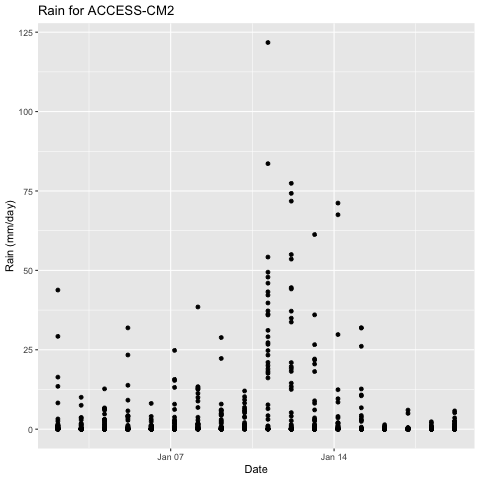

In [92]:
%%R


plot <- ggplot(result, aes(x=time, y=rain)) + 
geom_point() + 
labs(x='Date', 
     y='Rain (mm/day)',
     title = 'Rain for ACCESS-CM2')
plot

In [ ]:
%%R

ggsave(plot

> Combining Data Comparison

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Adam Morphy | MacOS Big Sur | 8GB | 1.8 GHz Dual-Core Intel Core i5 | Yes | |
| Mukund Iyer | MacOS Monterey | 8GB | 1.4 GHz Quad-Core Intel Core i5 | Yes | |
| Julien Gordon | Ubuntu 20.04.4 LTS | 16GB | AMD® Ryzen 7 5800h with radeon graphics | Yes | |
| Shiva Shankar Jena | MacOS Catalina 10.15.7 | 4GB | 1.4 GHz Dual-Core Intel Core i5 | Yes | |